In [1]:
!pip3 install box2d-py

     |████████████████████████████████| 450kB 5.4MB/s 


In [2]:

"""
Import Libraryies
"""
import gym
import numpy as np
import collections
import random
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()


In [3]:
class DQNAgent:

    def __init__(self, n_states, n_actions, lr, gamma, ep, min_epsilon,ep_decay):
        
        """
        parameters
        """
        # environment
        self.n_states = n_states
        self.n_actions = n_actions
        
        # parameters
        self.gamma = gamma # discount factor
        self.epsilon = ep  # exploration rate
        self.epsilon_min = min_epsilon
        self.epsilon_decay = ep_decay
        self.learning_rate = lr
        self.memory = collections.deque(maxlen =50000)
        self.replay_count = 0
        
        # local network and target network
        self.q_local = self.build_dqn()
        self.q_target = self.build_dqn()

        
  
    def memorize(self, state, action, reward, next_state, done):
        
        self.memory.append((state, action, reward, next_state, done))
    
    def update(self):
     # print("update target network")
      self.q_target.set_weights(self.q_local.get_weights())
  
    def select_action(self, state):
        if np.random.rand()<=self.epsilon:
            return np.random.choice(self.n_actions)
        return np.argmax(self.q_local.predict(state)[0])
    
    def select_action_test(self, state):
        return np.argmax(self.q_local.predict(state)[0])
    
    def replay(self, batch_size,step):
        batch = random.sample(self.memory, batch_size)
        #target_f = self.model.predict_on_batch(batch[0])
        
        
        states = []
        actions = []
        next_states = []
        rewards = []
        finishes = []
        for state, action, reward, next_state, done in batch:
            states.append(state)
            actions.append(action)
            next_states.append(next_state)
            rewards.append(reward)
            finishes.append(done)
        states = np.array(states)
        actions = np.array(actions)
        next_states = np.array(next_states)
        rewards = np.array(rewards)
        finishes = np.array(finishes)
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        
        q_vals_next_state = self.q_target.predict_on_batch(next_states)
        q_vals_target = self.q_local.predict_on_batch(states)
        
        max_q_values_next_state = np.amax(q_vals_next_state, axis=1)
        q_vals_target[np.arange(batch_size), actions] = rewards + self.gamma * (max_q_values_next_state) * (1 - finishes)
        self.q_local.fit(states, q_vals_target, verbose=0)
        self.replay_count += 1

        
        if 0<=step<=50:
            self.epsilon = 0.5
        elif 50<step<=100:
            self.epsilon = 0.3
        elif 100<step<=300:
            self.epsilon = 0.2
        elif 300<step<=500:
            self.epsilon = 0.1
        elif 500<step<=1000:
            self.epsilon = 0.05
        else:
            self.epsilon = 0.01
    
    def build_dqn(self):      
        """
        Q-function Approximator
        """
        model = Sequential()
        model.add(Dense(32, input_dim = self.n_states, activation='relu'))
        model.add(Dense(64,  activation='relu'))
        model.add(Dense(self.n_actions, activation='linear'))
        model.compile(loss='mse', optimizer = Adam(lr=self.learning_rate))
        return model

    def save_model(self, name):
        self.q_local.save(name)

In [7]:
"""
Parameters
"""

MAX_MOVES =1000
AVG_REWARD_LEN = 100
TARGET_AVG_REWARD = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.001
GAMMA = 0.99
EPSILON = 1.0
MIN_EPSILON = 0.01
EPSILON_DECAY = 0.05
#TARGET_UPDATE = 20
"""
Randomization Seeds
"""
random_seed = 0

np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)
"""
Environment
"""
env = gym.make("LunarLander-v2")
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n
print(f"There are {n_states} states and {n_actions} actions in the Environment")

done = False
batch_size = BATCH_SIZE

e = 0

"""
Training DQN
"""
rewards_array = collections.defaultdict(list)
for TARGET_UPDATE in [10,20,30]:
  agent = DQNAgent(n_states, n_actions, lr = LEARNING_RATE,gamma = GAMMA, ep = EPSILON, min_epsilon = MIN_EPSILON,ep_decay = EPSILON_DECAY )
  rewards_array[TARGET_UPDATE] = []
  while True:
      state = env.reset()
      state = np.reshape(state, [1, n_states])
      t_rewards = 0
      step = 0
      e += 1
      while True:
        
      # env.render()
          action = agent.select_action(state)
          step += 1
          next_state, reward, done, _ = env.step(action)
          #reward = reward if not done else -10
          t_rewards += reward
          next_state = np.reshape(next_state, [1, n_states])
          agent.memorize(state, action, reward, next_state, done)
          state = next_state
      
          if step>MAX_MOVES:
              if e%50==0:
                  print("Over MAX_MOVES! episode: {}, score: {},Average Score:{} ,DONE at {}th steps "
                      .format(e, t_rewards, np.mean(rewards_array[TARGET_UPDATE][-100:]),step))
              rewards_array[TARGET_UPDATE].append(t_rewards)
              break
          if done:
              rewards_array[TARGET_UPDATE].append(t_rewards)
              if e%50==0:
                  print("episode: {}, score: {},Average Score:{} ,DONE at {}th steps "
                  .format(e, t_rewards, np.mean(rewards_array[TARGET_UPDATE][-100:]),step))
              break
          if len(agent.memory) > batch_size:
              agent.replay(batch_size,e)
        
          if e%TARGET_UPDATE==0:
              agent.update()
          
      if e>100 and np.mean(rewards_array[TARGET_UPDATE][-100:])>=TARGET_AVG_REWARD:
          agent.save_model(f'dqn_defined_epsilon_update_{TARGET_UPDATE}')
          print("model saved!")
          break
  #loaded_m =keras.models.load_model('dqn')
  #print("model loaded!")

There are 8 states and 4 actions in the Environment


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


episode: 50, score: -59.016918310914726,Average Score:-152.00169212870958 ,DONE at 136th steps 
episode: 100, score: -53.086130424643905,Average Score:-138.65571286614457 ,DONE at 1000th steps 
episode: 150, score: -220.05970582295083,Average Score:-72.53446448753273 ,DONE at 223th steps 
episode: 200, score: 93.74204394472318,Average Score:-10.811060733326046 ,DONE at 1000th steps 
episode: 250, score: 136.89660223131776,Average Score:25.570276751278726 ,DONE at 1000th steps 
episode: 300, score: -109.85336683126894,Average Score:87.61784414915293 ,DONE at 139th steps 
episode: 350, score: 195.75057510902155,Average Score:102.29070025590077 ,DONE at 870th steps 
episode: 400, score: 234.44137505299665,Average Score:37.327928031450085 ,DONE at 727th steps 
episode: 450, score: 247.47534676374582,Average Score:62.508991231304364 ,DONE at 893th steps 
episode: 500, score: 238.66311521184076,Average Score:140.50997939713397 ,DONE at 496th steps 
episode: 550, score: 228.64548577969725,Ave

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


episode: 950, score: -141.49840192583827,Average Score:-219.71598054034564 ,DONE at 157th steps 
episode: 1000, score: -65.0584455127627,Average Score:-155.12699621639578 ,DONE at 82th steps 
episode: 1050, score: -73.88323419933074,Average Score:-117.25963859317521 ,DONE at 1000th steps 
episode: 1100, score: -52.78655762902715,Average Score:-98.91758283526404 ,DONE at 1000th steps 
episode: 1150, score: -47.76508635483533,Average Score:-81.60262203315872 ,DONE at 1000th steps 
episode: 1200, score: 242.43165948335658,Average Score:-38.39517385274033 ,DONE at 551th steps 
episode: 1250, score: 296.9226921023555,Average Score:47.26604158166053 ,DONE at 231th steps 
episode: 1300, score: 206.42133433139423,Average Score:144.64890866466783 ,DONE at 197th steps 
INFO:tensorflow:Assets written to: dqn_defined_epsilon_update_20/assets
model saved!


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


episode: 1350, score: -717.8050880422629,Average Score:-477.35405823553737 ,DONE at 282th steps 
episode: 1400, score: -44.80807003775791,Average Score:-211.9830997240532 ,DONE at 1000th steps 
episode: 1450, score: -101.37406005982098,Average Score:-100.1833651894491 ,DONE at 1000th steps 
episode: 1500, score: 31.018675346304605,Average Score:-70.08359297133629 ,DONE at 78th steps 
episode: 1550, score: -68.28963402685112,Average Score:-65.75763483640623 ,DONE at 241th steps 
episode: 1600, score: -38.52307201666925,Average Score:-60.775005685329205 ,DONE at 1000th steps 
episode: 1650, score: 12.197777873389938,Average Score:-56.736156571813154 ,DONE at 98th steps 
episode: 1700, score: -88.0292048468951,Average Score:-88.4247982118138 ,DONE at 289th steps 
episode: 1750, score: 164.00928299400914,Average Score:-77.43955119268233 ,DONE at 880th steps 
episode: 1800, score: 236.82921302788083,Average Score:69.58674292133337 ,DONE at 575th steps 
episode: 1850, score: -78.887129881628

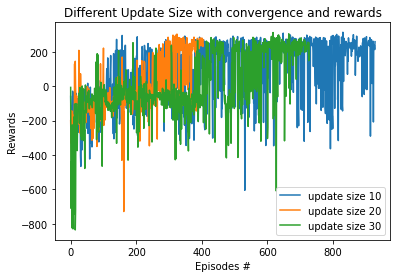

In [9]:

import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel("Episodes #")
plt.ylabel("Rewards")
plt.title("Different Update Size with convergence and rewards")
for update_size in rewards_array:
    plt.plot(range(len(rewards_array[update_size])),rewards_array[update_size],label = 'update size %d'%update_size)
plt.legend()
plt.show()


In [13]:
test_reward = []
agent_test = DQNAgent(n_states, n_actions, lr = LEARNING_RATE,gamma = GAMMA, ep = EPSILON, min_epsilon = MIN_EPSILON,ep_decay = EPSILON_DECAY )
agent_test.q_local = keras.models.load_model('dqn_defined_epsilon_update_30')
env = gym.make('LunarLander-v2')
for i in range(100):
    state = env.reset()
    state = np.reshape(state, [1, n_states])
    t_rewards = 0
    while True:
        action = agent_test.select_action_test(state)
        next_state, reward, done, _ = env.step(action)
        t_rewards += reward
        next_state = np.reshape(next_state, [1, n_states])
        #agent.memorize(state, action, reward, next_state, done)
        state = next_state
        if done:
            test_reward.append(t_rewards)
            #print(f"{i}th reward:{t_rewards}")   
            break
print(f"average reward in testy {np.mean(test_reward)}")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


average reward in testy 239.02727539800762


In [14]:
test_reward = []
agent_test = DQNAgent(n_states, n_actions, lr = LEARNING_RATE,gamma = GAMMA, ep = EPSILON, min_epsilon = MIN_EPSILON,ep_decay = EPSILON_DECAY )
agent_test.q_local = keras.models.load_model('dqn_defined_epsilon_update_10')
env = gym.make('LunarLander-v2')
for i in range(100):
    state = env.reset()
    state = np.reshape(state, [1, n_states])
    t_rewards = 0
    while True:
        action = agent_test.select_action_test(state)
        next_state, reward, done, _ = env.step(action)
        t_rewards += reward
        next_state = np.reshape(next_state, [1, n_states])
        #agent.memorize(state, action, reward, next_state, done)
        state = next_state
        if done:
            test_reward.append(t_rewards)
            #print(f"{i}th reward:{t_rewards}")   
            break
print(f"average reward in testy {np.mean(test_reward)}")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


average reward in testy 218.57569807027477
